#**IMAGE CLASSIFICATION OF X-RAYS TO DETERMINE PNEUMONIA**

##***LIBRARY IMPORTS AND DATA LOADING***

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import tensorflow as tf
import zipfile
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
local_zip = '/content/drive/MyDrive/chest_xray_2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
base_dir = '/content/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

##***EDA***

In [5]:

IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  image_size=IMG_SIZE)

Found 917 files belonging to 2 classes.
Found 425 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

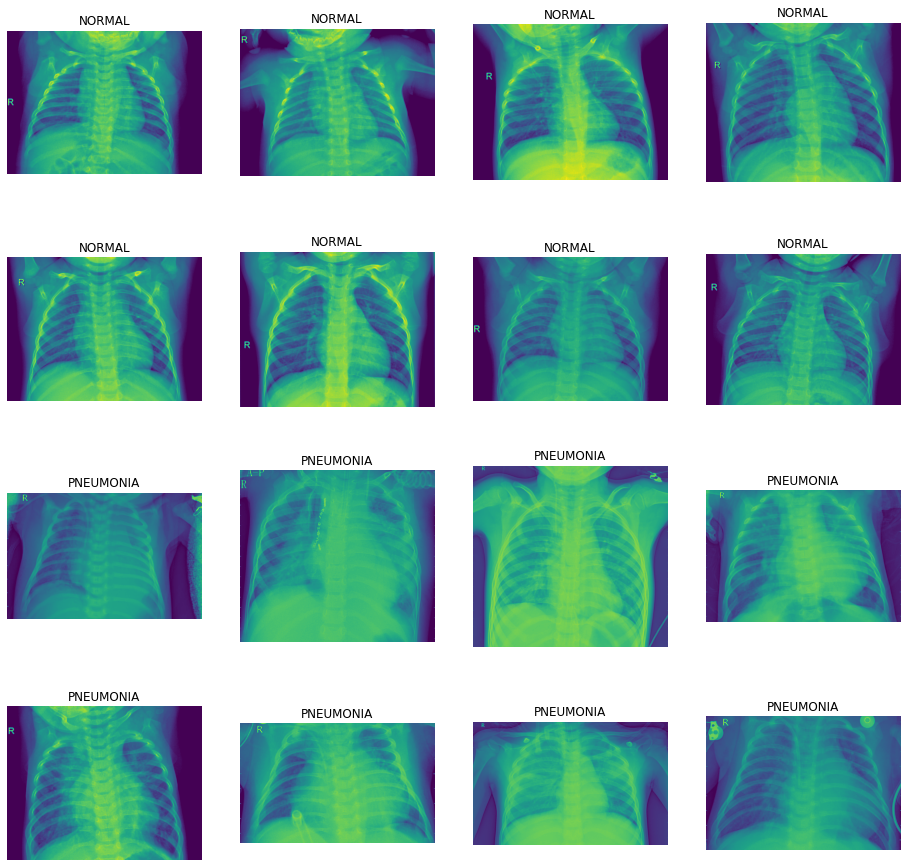

In [7]:
#View 8 Normal and 8 Pneumonia X-rays

train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)
nrows = 4
ncols = 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 8
next_normal = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
next_pneumonia = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal+next_pneumonia):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis ('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  if img_path in next_normal:
    plt.title("NORMAL")
  else:
    plt.title("PNEUMONIA")


In [8]:
len(train_normal_fnames)

521

In [9]:
len(train_pneumonia_fnames)

396

In [10]:
test_normal_fnames = os.listdir(test_normal_dir)
test_pneumonia_fnames = os.listdir(test_pneumonia_dir)

In [11]:
len(test_normal_fnames)

234

In [12]:
len(test_pneumonia_fnames)

390

In [13]:
#Increase performance by tuning the dataset dynamically

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
#Create augmented data to increase dataset size
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

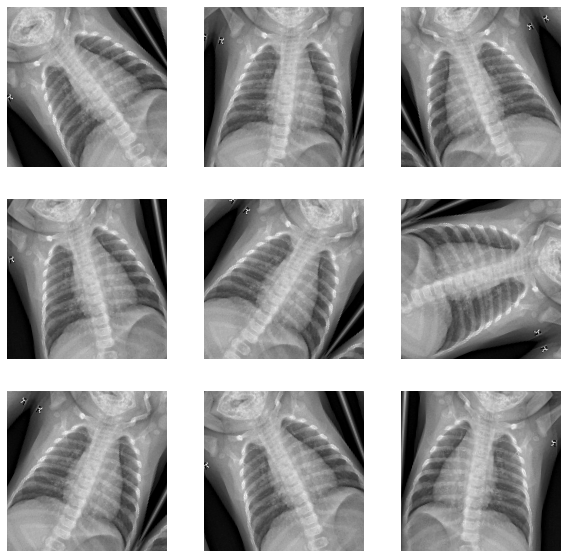

In [15]:
#View some augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset= -1)

##***MODELLING USING CONVOLUTIONAL NEURAL NETS***

In [ ]:
#Convolutional Neural Net Layers

img_input = layers.Input(shape=(160,160,3))
x = data_augmentation(img_input)
L = layers.Conv2D(32,3, activation='relu')(x)
L = layers.MaxPooling2D(2)(L)

L = layers.Conv2D(32,3, activation='relu')(L)
L = layers.MaxPooling2D(2)(L)

L = layers.Conv2D(64,3, activation='relu')(L)
L = layers.MaxPooling2D(2)(L)

L = layers.Conv2D(64,3, activation='relu')(L)
L = layers.MaxPooling2D(2)(L)

L = layers.Conv2D(64,3, activation='relu')(L)
L = layers.MaxPooling2D(2)(L)

Full Connection:

In [ ]:
F = layers.Flatten()(L)
F = layers.Dense(512, activation='relu')(F)
output = layers.Dense(1, activation='sigmoid')(F)

Create Model:

In [ ]:
model = Model(img_input, output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 36, 36, 64)        1849

###False Positive Metric

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=[tf.keras.metrics.FalsePositives()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
29/29 [==============================] - 43s 1s/step - loss: 0.4533 - false_positives: 71.0000 - val_loss: 0.2099 - val_false_positives: 11.0000
Epoch 2/15
29/29 [==============================] - 41s 1s/step - loss: 0.2207 - false_positives: 32.0000 - val_loss: 0.2095 - val_false_positives: 11.0000
Epoch 3/15
29/29 [==============================] - 41s 1s/step - loss: 0.2006 - false_positives: 28.0000 - val_loss: 0.3324 - val_false_positives: 19.0000
Epoch 4/15
29/29 [==============================] - 41s 1s/step - loss: 0.3859 - false_positives: 39.0000 - val_loss: 0.1841 - val_false_positives: 5.0000
Epoch 5/15
29/29 [==============================] - 41s 1s/step - loss: 0.1874 - false_positives: 21.0000 - val_loss: 0.3240 - val_false_positives: 35.0000
Epoch 6/15
29/29 [==============================] - 41s 1s/step - loss: 0.1783 - false_positives: 26.0000 - val_loss: 0.2135 - val_false_positives: 4.0000
Epoch 7/15
29/29 [==============================] - 41s 1s/step - 

In [ ]:
scores = model.evaluate(validation_dataset)

print("Loss of the model: %.2f"%(scores[0]))
print("Validation Accuracy: %.2f%%"%(scores[1] * 100))

14/14 [==============================] - 6s 309ms/step - loss: 0.1832 - acc: 0.9247
Loss of the model: 0.18
Validation Accuracy: 92.47%


In [ ]:
scores = model.evaluate(test_dataset)

print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

20/20 [==============================] - 7s 318ms/step - loss: 0.3585 - acc: 0.8157
Loss of the model: 0.36
Test Accuracy: 81.57%


###Recall Metric

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=[tf.keras.metrics.Recall()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
29/29 [==============================] - 43s 1s/step - loss: 0.5546 - recall_1: 0.7172 - val_loss: 0.2787 - val_recall_1: 0.8426
Epoch 2/15
29/29 [==============================] - 41s 1s/step - loss: 0.3349 - recall_1: 0.8384 - val_loss: 0.2939 - val_recall_1: 0.9028
Epoch 3/15
29/29 [==============================] - 41s 1s/step - loss: 0.2965 - recall_1: 0.8662 - val_loss: 0.2691 - val_recall_1: 0.9444
Epoch 4/15
29/29 [==============================] - 41s 1s/step - loss: 0.3421 - recall_1: 0.8434 - val_loss: 0.6241 - val_recall_1: 0.3843
Epoch 5/15
29/29 [==============================] - 41s 1s/step - loss: 0.3012 - recall_1: 0.8409 - val_loss: 0.3513 - val_recall_1: 0.7222
Epoch 6/15
29/29 [==============================] - 41s 1s/step - loss: 0.2526 - recall_1: 0.8788 - val_loss: 0.5782 - val_recall_1: 0.5972
Epoch 7/15
29/29 [==============================] - 41s 1s/step - loss: 0.3327 - recall_1: 0.8308 - val_loss: 0.1865 - val_recall_1: 0.9028
Epoch 8/15
29/29 [==

In [ ]:
scores = model.evaluate(validation_dataset)

print("Loss of the model: %.2f"%(scores[0]))
print("Validation Recall: %.2f%%"%(scores[1] * 100))

14/14 [==============================] - 6s 308ms/step - loss: 0.6932 - recall_1: 0.9954
Loss of the model: 0.69
Validation Recall: 99.54%


In [ ]:
scores = model.evaluate(test_dataset)

print("Loss of the model: %.2f"%(scores[0]))
print("Test Recall: %.2f%%"%(scores[1] * 100))

20/20 [==============================] - 7s 318ms/step - loss: 1.0136 - recall_1: 0.9897
Loss of the model: 1.01
Test Recall: 98.97%


##TESTING

In [ ]:
from PIL import Image

In [ ]:
from keras.models import load_model

model.save("my_model") 

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
reconstructed_model = tf.keras.models.load_model("my_model")

[[0.8999821]]
predicted: PNEUMONIA


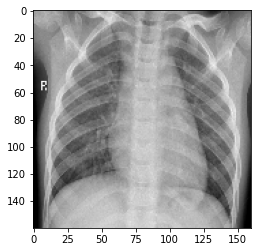

In [ ]:
def predict_image(filename):
    img_height, img_width  = 160, 160
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(img_height, img_width))
    image = tf.keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1, 160,160,3)
    #model = load_model('pneumonia_cnn_csv.h5')
    prediction = reconstructed_model.predict(image)
    plt.imshow(img)
    print(prediction)
    if(prediction[0] > 0.5):
        print("predicted: PNEUMONIA")
    else:
        print("predicted: NORMAL")
   
predict_image("/content/PNEUMONIA2-IM-0361-0001.jpeg")
